In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from model import RedCNN
from misc import *
from customDataset import CatdogDataset
import cv2
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil

from PIL import Image
from IPython.display import display
import warnings
from sklearn.preprocessing import normalize
warnings.filterwarnings('ignore')

In [6]:
gtpath="../dogData_20/gt/"
gtfiles=[]
for folder, subfolder, filenames in os.walk(gtpath):
    for files in filenames:
        gtfiles.append(files)
        

noisepath="../dogData_20/noise/"
noisefiles=[]
for folder, subfolder, filenames in os.walk(noisepath):
    for files in filenames:
        noisefiles.append(files)
        
#check whether both noise and gt have same files
print(gtfiles==noisefiles)

#Due to computational limitation, I only take 200 images
gtfiles_=gtfiles[:1000]

True


In [7]:
m1dataset= CatdogDataset(data_path=noisepath,target_path=gtpath,filenames=gtfiles_)
train_size=int(0.8*len(m1dataset))
test_size=len(m1dataset)-train_size
trainset,testset=random_split(m1dataset,[train_size,test_size],generator=torch.manual_seed(42))


In [4]:
torch.manual_seed(42)
model=RedCNN()
print(model)
criterion=nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


RedCNN(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_output): ConvTranspose2d(96, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [5]:
##Training
optimizer.zero_grad()

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)


losses_batch=[]
trained_psnr=[]
psnr=[]
for epoch in range(3):
    
    for i, data in enumerate(train_loader):

        inputt, target=data

        target_pred=model(inputt)

        img=inputt.detach().numpy()
        img_gt=target.detach().numpy()
        recon_image=target_pred.detach().numpy()
        
        
        for j in range(len(target)):
            psnr.append(cv2.PSNR(img[j],img_gt[j]))
            trained_psnr.append(cv2.PSNR(img[j],recon_image[j]))

        loss=criterion(target_pred,target)
        losses_batch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i%5==0):
            
            print(f"Epoch: {epoch} Loss:{loss.item()} Batch:{i}")




Epoch: 0 Loss:480.05963134765625 Batch:0
Epoch: 0 Loss:277.0790100097656 Batch:5
Epoch: 0 Loss:157.69110107421875 Batch:10
Epoch: 0 Loss:115.09410095214844 Batch:15
Epoch: 0 Loss:93.47171783447266 Batch:20
Epoch: 1 Loss:96.68049621582031 Batch:0
Epoch: 1 Loss:95.1640396118164 Batch:5
Epoch: 1 Loss:76.26006317138672 Batch:10
Epoch: 1 Loss:85.61662292480469 Batch:15
Epoch: 1 Loss:82.22093963623047 Batch:20
Epoch: 2 Loss:84.13529205322266 Batch:0
Epoch: 2 Loss:72.34640502929688 Batch:5
Epoch: 2 Loss:72.54790496826172 Batch:10
Epoch: 2 Loss:61.597049713134766 Batch:15
Epoch: 2 Loss:68.36820220947266 Batch:20


In [6]:
fisher_dict={}
param_dict={}
            
for name, param in model.named_parameters():
    
    param_dict[name] = param.data.clone()
        
    fisher_dict[name] = param.grad.data.clone().pow(2)

param_dictfile="./saved_fisherinfo/task1_param_dict.pth.tar"
fisher_dictfile="./saved_fisherinfo/task1_fisher_dict.pth.tar"
trained_psnrfile="./psnr_data/task1_by_task1_trainfiles.pth.tar"
psnr_file="./psnr_data/task1_trainfiles.pth.tar"
loss_file="./saved_loss/task1_loss.pth.tar"

torch.save(fisher_dict,fisher_dictfile)
torch.save(param_dict,param_dictfile)
torch.save(trained_psnr,trained_psnrfile)
torch.save(psnr,psnr_file)

modelfile="./saved_models/task1_model.pth.tar"

torch.save(model.state_dict(),modelfile)

In [7]:
torch.save(losses_batch,loss_file)

# Model Diagnostics 

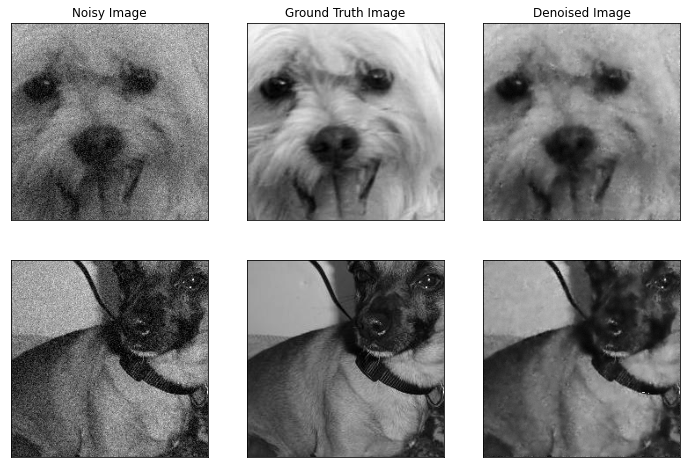

In [8]:
##Visualize the result with the images
check_images(trainset[100],testset[9],model)

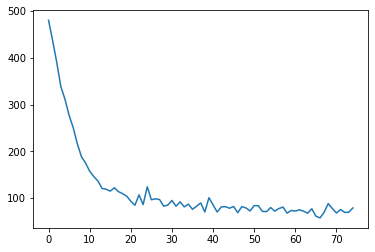

In [10]:
#plopling the loss vs batch
plt.plot(list(range(75)),losses_batch)

In [11]:
##PSNR of training data
print(f"PSNR Training Set: {statistics.mean(psnr)}")
print(f"PSNR after applying the model: {statistics.mean(trained_psnr)}")

PSNR Training Set: 21.58059948281782
PSNR after applying the model: 23.521303513583963


In [12]:
test_psnrfile="./psnr_data/task1_testfiles.pth.tar"
test_modelpsnrfile="./psnr_data/task1_by_task1_testfiles.pth.tar"

test1_psnr=gt_psnr(testset)
test_modelpsnr=test_psnr(testset,model)

torch.save(test1_psnr,test_psnrfile)
torch.save(test_modelpsnr,test_modelpsnrfile)

PSNR test set: 21.564498637116245
PSNR after model: 22.097019915782052


# Continual Forgetting

In [22]:
#Load model without EWC

model_noewc=RedCNN()
model_noewc.load_state_dict(torch.load("./saved_models/task2noewc_model.pth.tar"))

<All keys matched successfully>

In [23]:
test_clmodelpsnrfile="./psnr_data/task1_by_task2noewc_testfiles.pth.tar"
test_clmodelpsnr=test_psnr(testset,model_noewc)

torch.save(test_clmodelpsnr,test_clmodelpsnrfile)

PSNR after model: 21.90339290576968


In [10]:
##Load model with EWC
model_ewc=RedCNN()
model_ewc.load_state_dict(torch.load("./saved_models/task2ewc_model.pth.tar"))

<All keys matched successfully>

In [11]:
test_cl2modelpsnrfile="./psnr_data/task1_by_task2ewc_testfiles.pth.tar"
test_cl2modelpsnr=test_psnr(testset,model_ewc)

torch.save(test_cl2modelpsnr,test_cl2modelpsnrfile)

PSNR after model: 21.80404083638307
